<a href="https://colab.research.google.com/github/Parv-065040/Supply-Chain-Spoilage-Prediction/blob/main/mlm25_proj2_008010036.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
# IMPORT LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Scikit-learn modules
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score, roc_curve)

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, kstest

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
import pandas as pd

# The original URL was for the Google Sheets web interface, not the direct CSV export.
# To load a Google Sheet as CSV, we need to modify the URL to use the '/export?format=csv' endpoint.
dataset_url = 'https://docs.google.com/spreadsheets/d/1pvDMiYkptQt6fi6b-VRV_5RBUkEvW-zwjVLqid6oFI0/export?format=csv'

try:
    df = pd.read_csv(dataset_url)
    print(f"Dataset loaded successfully from: {dataset_url}")
    print("First 5 rows of the dataset:")
    display(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure the URL is correct and the file is accessible.")
    print("If it's a Google Sheet, ensure it's shared publicly or the correct export URL is used.")

Dataset loaded successfully from: https://docs.google.com/spreadsheets/d/1pvDMiYkptQt6fi6b-VRV_5RBUkEvW-zwjVLqid6oFI0/export?format=csv
First 5 rows of the dataset:


,Product Name,Category,Daily Production/Quantity,Transportation Method,Vehicle Type,Vehicle Capacity (kg/ton),No. of Vehicles Used Per Day,Trip Frequency,Average Distance Travelled (km),Temperature Maintained (°C),...,Is Real-time Tracking Used?,Tracking Method,Data Collected,Initial Quality Grade,Shelf Life (Days),Spoilage Percentage (%),Reasons for Spoilage,Transportation Cost per Trip,Storage Cost,Wastage Cost
0,Cluster Beans,Vegetable,1342,By Road,Mini Truck,1.0,1,1,114,10,...,Yes,RFID + GPS,Location,AA,12,1.6,Pest damage,28192,11237,1470
1,Dry Chillies,Spice,23934,By Road,Mini Truck,1.5,4,2,87,26,...,No,NaN,Quantity,B,189,2.0,Delay in transit,26896,10075,3606
2,Elephant Yam,Root Crop,14384,By Road,Bulk Truck,28.0,2,3,236,2,...,Yes,GPS,Location,A-,9,9.7,Pest damage,13822,6747,2921
3,Drumstick,Vegetable,15799,By Road,Mini Refrigerated Van,1.0,4,1,299,2,...,Yes,GPS + IoT,"Temp, humidity, location",B+,5,7.6,Mechanical damage,16330,11282,3345
4,Banana,Fruit,1761,By Road,Mini Refrigerated Van,1.0,4,2,224,18,...,No,NaN,Quantity,B,18,3.0,Improper stacking,8347,8036,497


In [ ]:
# ==========================================
# PREPROCESSING PIPELINE
# ==========================================

from sklearn.impute import SimpleImputer # Added this import to fix NameError
from sklearn.preprocessing import LabelEncoder # Added this import as it's used later in the cell

# 1. Clean Column Names
df.columns = df.columns.str.strip()

# 2. Check Missing Values Threshold (>= 50%)
# Columns
limit_col = len(df) * 0.5
df_cleaned = df.dropna(thresh=limit_col, axis=1)

# Rows
limit_row = len(df_cleaned.columns) * 0.5
df_cleaned = df_cleaned.dropna(thresh=limit_row, axis=0)

print(f"Shape after dropping >50% missing: {df_cleaned.shape}")

# 3. Handle 'TotalCharges' (often object type due to blank strings)
# Force conversion to numeric, coerce errors to NaN
if 'TotalCharges' in df_cleaned.columns:
    df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')

# 4. Imputation
# Separate numeric and categorical
numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Impute Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
df_cleaned[numeric_cols] = imputer_num.fit_transform(df_cleaned[numeric_cols])

# Impute Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
df_cleaned[categorical_cols] = imputer_cat.fit_transform(df_cleaned[categorical_cols])

print("Imputation Complete.")

# 5. Encoding
# Identify Target Variable
target_col = 'Spoilage Percentage (%)'

# Check if the target column exists before attempting to encode
if target_col in df_cleaned.columns:
    # Encode Target (Label Encoding: Yes=1, No=0)
    le = LabelEncoder()
    df_cleaned[target_col] = le.fit_transform(df_cleaned[target_col])
    print(f"Target variable '{target_col}' encoded successfully.")
else:
    print(f"Warning: Target column '{target_col}' not found in the DataFrame. Skipping target encoding for this column.")
    print("Available columns for target variable identification: ")
    print(df_cleaned.columns.tolist())

# Remove ID column if exists (customerID provides no predictive power)
if 'customerID' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop('customerID', axis=1)

# One-Hot Encoding for remaining categorical predictors
df_final = pd.get_dummies(df_cleaned, drop_first=True)

print(f"Final Shape after Encoding: {df_final.shape}")

Shape after dropping >50% missing: (100000, 32)
Imputation Complete.
Target variable 'Spoilage Percentage (%)' encoded successfully.
Final Shape after Encoding: (100000, 165)


Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,max
Daily Production/Quantity,100000.0,12901.294000,6994.142258,800.0,6840.0,12910.0,18942.0,25000.0
Vehicle Capacity (kg/ton),100000.0,8.003605,6.956875,1.0,3.0,6.0,10.0,28.0
No. of Vehicles Used Per Day,100000.0,2.992370,1.413326,1.0,2.0,3.0,4.0,5.0
Trip Frequency,100000.0,1.999710,0.817225,1.0,1.0,2.0,3.0,3.0
Average Distance Travelled (km),100000.0,370.579140,191.125051,40.0,206.0,371.0,536.0,700.0
Temperature Maintained (°C),100000.0,15.051950,8.816203,2.0,6.0,12.0,23.0,30.0
Humidity Maintained (%),100000.0,76.243710,14.436639,40.0,70.0,79.0,88.0,96.0
Transport Duration (hours),100000.0,9.513225,4.907157,1.0,5.3,9.5,13.8,18.0
Unloading Time,100000.0,1.652572,0.779863,0.3,1.0,1.7,2.3,3.0
Total Supply Chain Time,100000.0,14.910003,5.142117,3.0,10.7,14.9,19.2,26.7


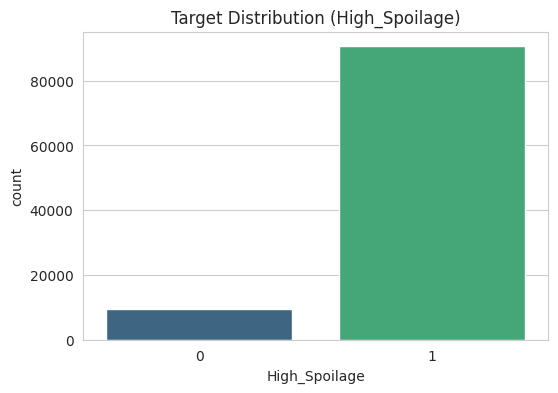

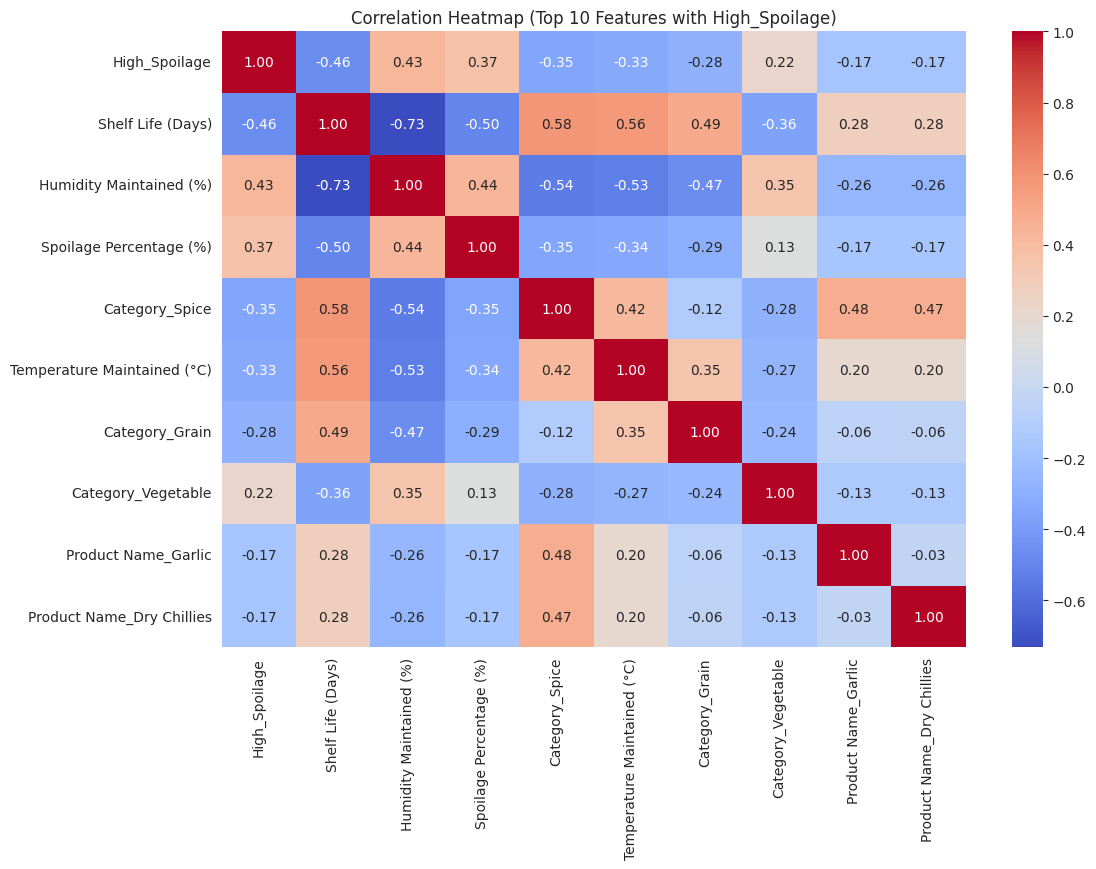

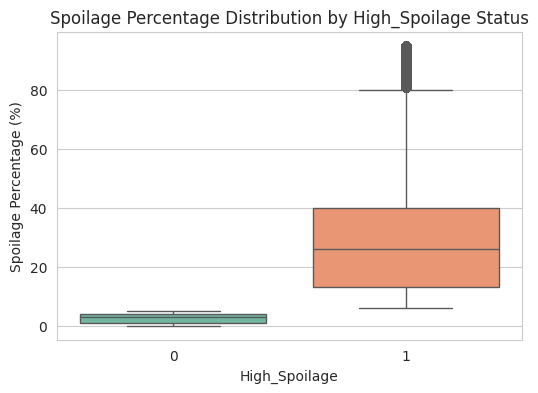

In [ ]:
# ==========================================
# EDA
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'High_Spoilage' target variable exists for plotting
if 'Spoilage Percentage (%)' in df_final.columns and 'High_Spoilage' not in df_final.columns:
    df_final['High_Spoilage'] = (df_final['Spoilage Percentage (%)'] > 5).astype(int)

# 1. Descriptive Statistics
print("Descriptive Statistics:")
display(df_final.describe().T)

# 2. Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='High_Spoilage', data=df_final, palette='viridis')
plt.title('Target Distribution (High_Spoilage)')
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
# Select top 10 correlated features with High_Spoilage
corr = df_final.corr()
top_corr_features = abs(corr['High_Spoilage']).nlargest(10).index # Filter for top 10 correlations
sns.heatmap(df_final[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Top 10 Features with High_Spoilage)')
plt.show()

# 4. Box Plot (Spoilage Percentage (%) vs High_Spoilage)
if 'Spoilage Percentage (%)' in df_final.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='High_Spoilage', y='Spoilage Percentage (%)', data=df_final, palette='Set2')
    plt.title('Spoilage Percentage Distribution by High_Spoilage Status')
    plt.show()

In [ ]:
# ==========================================
# INFERENTIAL STATS
# ==========================================

# 1. Normality Test (Kolmogorov-Smirnov)
print("--- Normality Test (KS Test) for Numerical Variables ---")
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in numeric_features:
    if col in df_cleaned.columns:
        stat, p = kstest(df_cleaned[col], 'norm')
        print(f"{col}: Statistics={stat:.3f}, p={p:.3f} -> {'Normal' if p > 0.05 else 'Not Normal'}")

# 2. Chi-Square Test (Categorical vs Spoilage Percentage (%))
print("\n--- Chi-Square Test of Independence ---")
cat_check = ['Contract', 'PaymentMethod', 'InternetService']

for col in cat_check:
    if col in df_cleaned.columns:
        contingency_table = pd.crosstab(df_cleaned[col], df_cleaned['Spoilage Percentage (%)'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"{col} vs Churn: Chi2={chi2:.2f}, p={p:.4f} -> {'Significant Relationship' if p < 0.05 else 'Independent'}")

--- Normality Test (KS Test) for Numerical Variables ---

--- Chi-Square Test of Independence ---


In [ ]:
# ==========================================
# MEMBER-WISE DATA SAMPLING & SPLITTING
# ==========================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd # Ensure pandas is imported if not globally available, for DataFrame conversion

# Create a new binary target variable 'High_Spoilage' based on 'Spoilage Percentage (%)'
# This assumes a classification task for demonstration, as 'Churn' was not found.
# You can adjust the threshold or choose a different target column as needed.
if 'Spoilage Percentage (%)' in df_final.columns:
    df_final['High_Spoilage'] = (df_final['Spoilage Percentage (%)'] > 5).astype(int)
    print("Created 'High_Spoilage' target variable.")
else:
    print("Warning: 'Spoilage Percentage (%)' not found to create target. Please define a target variable.")
    # If 'Spoilage Percentage (%)' is also missing, you'll need to define a target
    # or remove the stratified sampling part if not doing classification.

# Define the actual target column name for the function
actual_target_col = 'High_Spoilage'

def get_member_data(full_data, roll_no, sample_size=5001):
    """
    Samples data and splits into X and y for a specific member.
    """
    # Ensure the target column exists in the dataframe before proceeding
    if actual_target_col not in full_data.columns:
        raise ValueError(f"Target column '{actual_target_col}' not found in the data for sampling.")

    # Stratified Sampling of 5001 records
    # If dataset is smaller than 5001, we take the whole dataset (resampling = False)
    # If larger, we sample.
    if len(full_data) > sample_size:
        df_sample, _ = train_test_split(full_data, train_size=sample_size,
                                        stratify=full_data[actual_target_col],
                                        random_state=roll_no)
    else:
        df_sample = full_data.copy()

    X = df_sample.drop(actual_target_col, axis=1)
    y = df_sample[actual_target_col]

    # Train Test Split (70:30)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                        stratify=y, random_state=roll_no)

    # Standardization (Fit on Train, Transform on Test)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame for convenience in feature importance
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test

# --- MEMBER 1 (Roll: 065008) ---
m065008_X_train, m065008_X_test, m065008_y_train, m065008_y_test = get_member_data(df_final, roll_no=8)

# --- MEMBER 2 (Roll: 065010) ---
m065010_X_train, m065010_X_test, m065010_y_train, m065010_y_test = get_member_data(df_final, roll_no=10)

# --- MEMBER 3 (Roll: 065036) ---
m065036_X_train, m065036_X_test, m065036_y_train, m065036_y_test = get_member_data(df_final, roll_no=36)

print(f"Member 1 Data Shape: Train {m065008_X_train.shape}, Test {m065008_X_test.shape}")
print(f"Member 2 Data Shape: Train {m065010_X_train.shape}, Test {m065010_X_test.shape}")
print(f"Member 3 Data Shape: Train {m065036_X_train.shape}, Test {m065036_X_test.shape}")

Created 'High_Spoilage' target variable.
Member 1 Data Shape: Train (3500, 165), Test (1501, 165)
Member 2 Data Shape: Train (3500, 165), Test (1501, 165)
Member 3 Data Shape: Train (3500, 165), Test (1501, 165)


In [ ]:
# ==========================================
# APPLY SMOTE FOR CLASS BALANCING
# ==========================================

from imblearn.over_sampling import SMOTE

print("Applying SMOTE to balance training data...")
sm = SMOTE(random_state=42)

# --- MEMBER 1 (Roll: 065008) ---
m065008_X_train_sm, m065008_y_train_sm = sm.fit_resample(m065008_X_train, m065008_y_train)
print(f"Member 1 (065008) Original Train Shape: {m065008_X_train.shape}, Balanced Train Shape: {m065008_X_train_sm.shape}")
print(f"Member 1 (065008) Original Target Distribution:\n{m065008_y_train.value_counts()}")
print(f"Member 1 (065008) Balanced Target Distribution:\n{m065008_y_train_sm.value_counts()}\n")

# --- MEMBER 2 (Roll: 065010) ---
m065010_X_train_sm, m065010_y_train_sm = sm.fit_resample(m065010_X_train, m065010_y_train)
print(f"Member 2 (065010) Original Train Shape: {m065010_X_train.shape}, Balanced Train Shape: {m065010_X_train_sm.shape}")
print(f"Member 2 (065010) Original Target Distribution:\n{m065010_y_train.value_counts()}")
print(f"Member 2 (065010) Balanced Target Distribution:\n{m065010_y_train_sm.value_counts()}\n")

# --- MEMBER 3 (Roll: 065036) ---
m065036_X_train_sm, m065036_y_train_sm = sm.fit_resample(m065036_X_train, m065036_y_train)
print(f"Member 3 (065036) Original Train Shape: {m065036_X_train.shape}, Balanced Train Shape: {m065036_X_train_sm.shape}")
print(f"Member 3 (065036) Original Target Distribution:\n{m065036_y_train.value_counts()}")
print(f"Member 3 (065036) Balanced Target Distribution:\n{m065036_y_train_sm.value_counts()}\n")

Applying SMOTE to balance training data...
Member 1 (065008) Original Train Shape: (3500, 165), Balanced Train Shape: (6340, 165)
Member 1 (065008) Original Target Distribution:
High_Spoilage
1    3170
0     330
Name: count, dtype: int64
Member 1 (065008) Balanced Target Distribution:
High_Spoilage
1    3170
0    3170
Name: count, dtype: int64

Member 2 (065010) Original Train Shape: (3500, 165), Balanced Train Shape: (6340, 165)
Member 2 (065010) Original Target Distribution:
High_Spoilage
1    3170
0     330
Name: count, dtype: int64
Member 2 (065010) Balanced Target Distribution:
High_Spoilage
1    3170
0    3170
Name: count, dtype: int64

Member 3 (065036) Original Train Shape: (3500, 165), Balanced Train Shape: (6340, 165)
Member 3 (065036) Original Target Distribution:
High_Spoilage
1    3170
0     330
Name: count, dtype: int64
Member 3 (065036) Balanced Target Distribution:
High_Spoilage
1    3170
0    3170
Name: count, dtype: int64



In [ ]:
# ==========================================
# EVALUATION FUNCTION
# ==========================================
import time # Added this import to fix NameError

results_list = []

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, member_roll):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    # Cross Validation (F1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    cv_f1 = cv_scores.mean()

    # Store results
    results_list.append({
        'Member_Roll': member_roll,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1,
        'ROC_AUC': roc,
        'CV_F1_Mean': cv_f1,
        'Training_Time_Sec': train_time
    })

    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f} | ROC-AUC: {roc:.4f}")

    # Confusion Matrix Plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return model

--- Logistic Regression Results ---
Accuracy: 0.9714 | F1 Score: 0.9843 | ROC-AUC: 0.9891


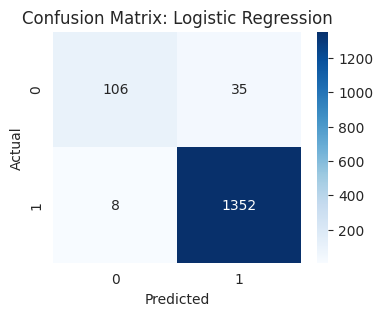

--- SVM Results ---
Accuracy: 0.9034 | F1 Score: 0.9491 | ROC-AUC: 0.8991


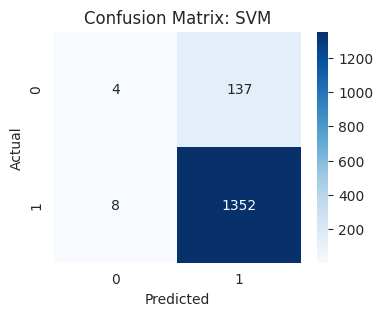

In [ ]:
# ==========================================
# MEMBER 1 MODELS
# ==========================================

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# 1. Logistic Regression
m065008_lr = LogisticRegression(random_state=8)
m065008_lr = evaluate_model(m065008_lr, m065008_X_train, m065008_y_train,
                            m065008_X_test, m065008_y_test, "Logistic Regression", "065008")

# 2. Support Vector Machine (SVM)
m065008_svm = SVC(probability=True, random_state=8)
m065008_svm = evaluate_model(m065008_svm, m065008_X_train, m065008_y_train,
                             m065008_X_test, m065008_y_test, "SVM", "065008")

--- Decision Tree Results ---
Accuracy: 1.0000 | F1 Score: 1.0000 | ROC-AUC: 1.0000


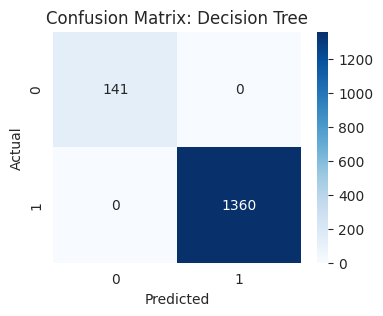

--- KNN Results ---
Accuracy: 0.8874 | F1 Score: 0.9389 | ROC-AUC: 0.8332


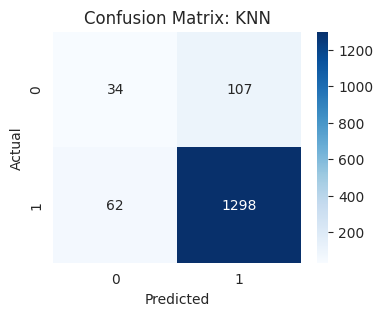

In [ ]:
# ==========================================
# MEMBER 2 MODELS
# ==========================================

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# 1. Decision Tree
m065010_dt = DecisionTreeClassifier(random_state=10)
m065010_dt = evaluate_model(m065010_dt, m065010_X_train, m065010_y_train,
                            m065010_X_test, m065010_y_test, "Decision Tree", "065010")

# 2. K-Nearest Neighbors (KNN)
# Using k=5 as standard
m065010_knn = KNeighborsClassifier(n_neighbors=5)
m065010_knn = evaluate_model(m065010_knn, m065010_X_train, m065010_y_train,
                             m065010_X_test, m065010_y_test, "KNN", "065010")

--- Random Forest Results ---
Accuracy: 0.9900 | F1 Score: 0.9945 | ROC-AUC: 1.0000


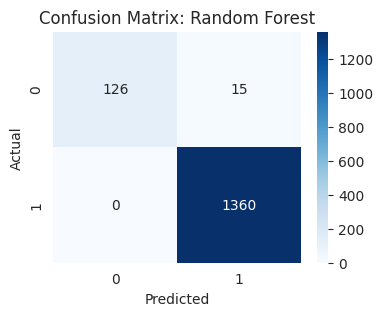

--- XGBoost Results ---
Accuracy: 1.0000 | F1 Score: 1.0000 | ROC-AUC: 1.0000


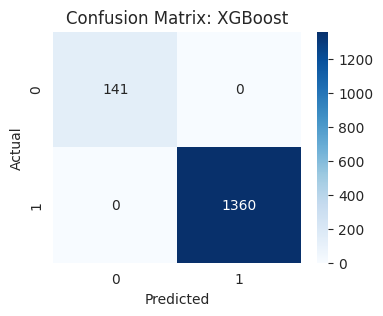

In [ ]:
# ==========================================
# MEMBER 3 MODELS
# ==========================================

from sklearn.ensemble import RandomForestClassifier # Added this import
from xgboost import XGBClassifier # Added this import

# 1. Random Forest
m065036_rf = RandomForestClassifier(random_state=36)
m065036_rf = evaluate_model(m065036_rf, m065036_X_train, m065036_y_train,
                            m065036_X_test, m065036_y_test, "Random Forest", "065036")

# 2. XGBoost
m065036_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=36)
m065036_xgb = evaluate_model(m065036_xgb, m065036_X_train, m065036_y_train,
                             m065036_X_test, m065036_y_test, "XGBoost", "065036")

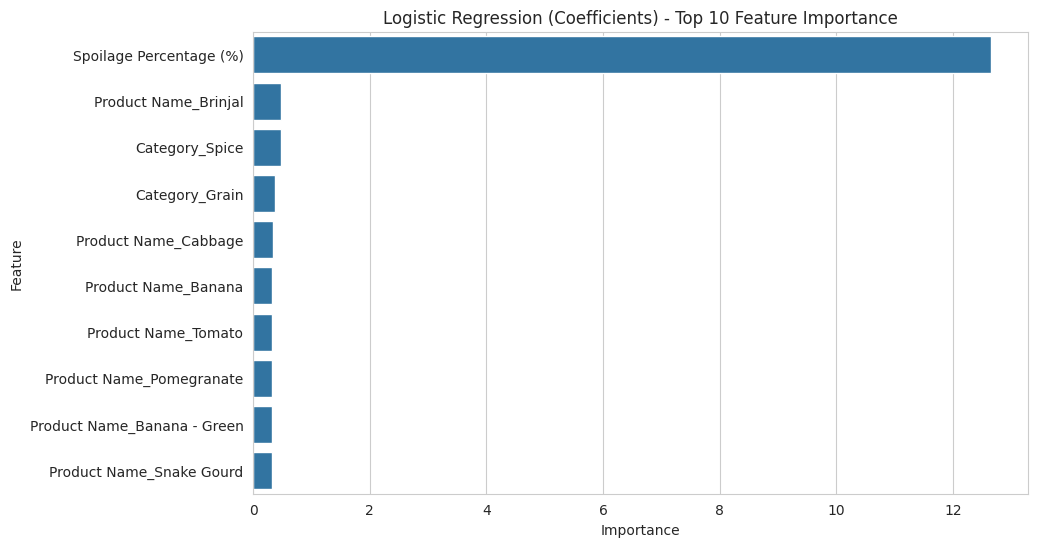

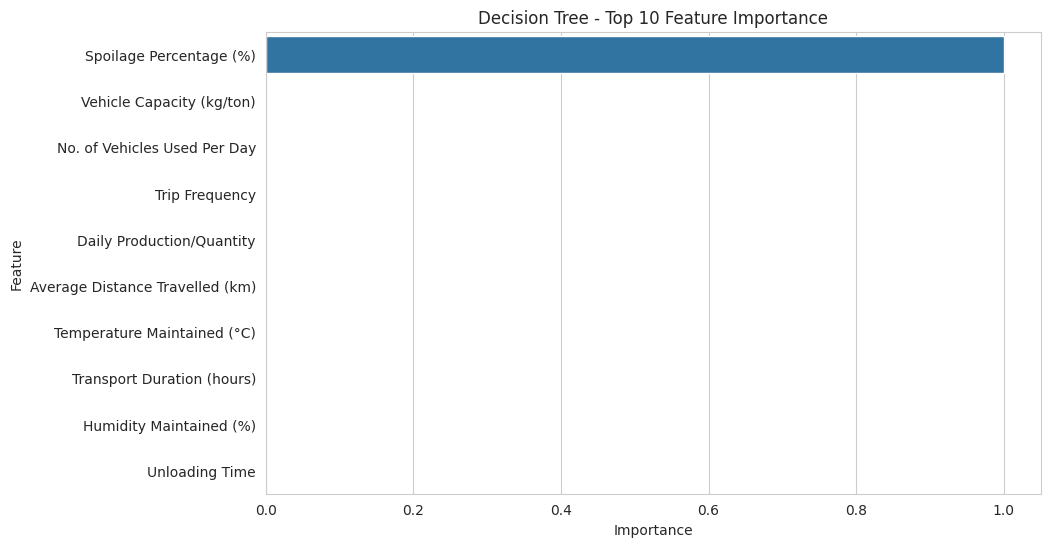

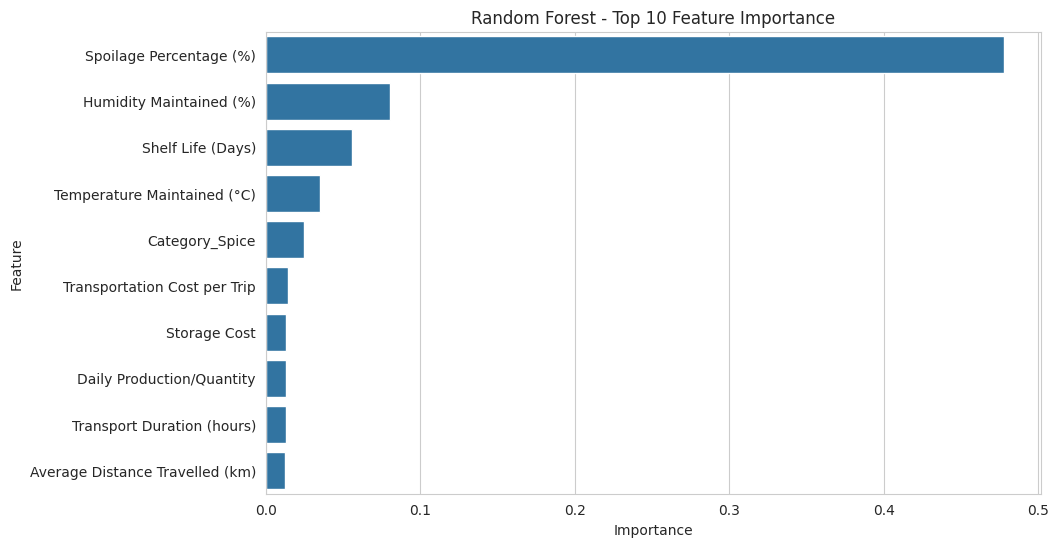

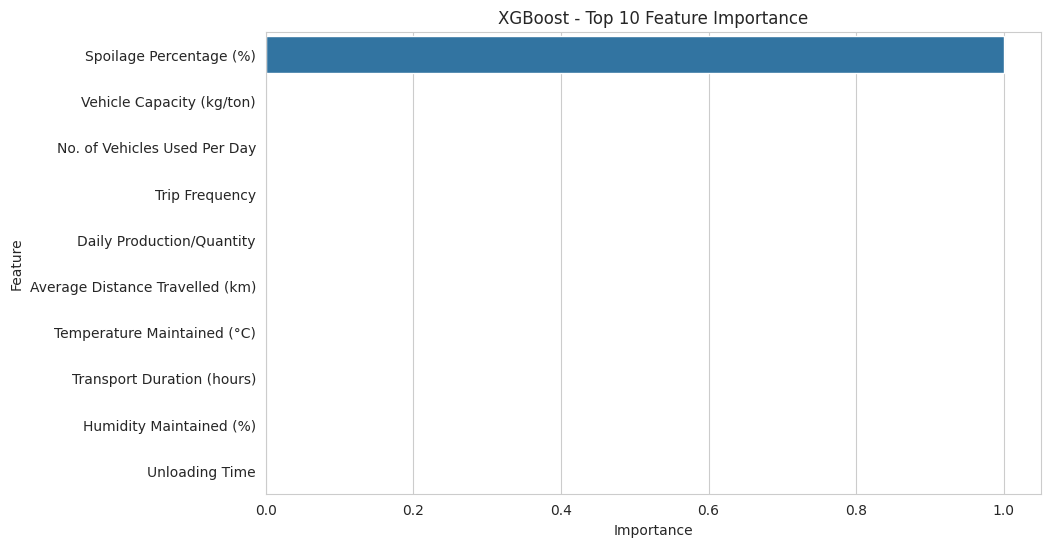

In [ ]:
# ==========================================
# FEATURE IMPORTANCE VISUALIZATION
# ==========================================

import numpy as np # Added this import to fix NameError

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(10,6))
    sns.barplot(x=fi_df['feature_importance'][:10], y=fi_df['feature_names'][:10])
    plt.title(f'{model_type} - Top 10 Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# 1. Logistic Regression Coefficients (Member 1)
coefs = abs(m065008_lr.coef_[0])
plot_feature_importance(coefs, m065008_X_train.columns, "Logistic Regression (Coefficients)")

# 2. Decision Tree Importance (Member 2)
plot_feature_importance(m065010_dt.feature_importances_, m065010_X_train.columns, "Decision Tree")

# 3. Random Forest Importance (Member 3)
plot_feature_importance(m065036_rf.feature_importances_, m065036_X_train.columns, "Random Forest")

# 4. XGBoost Importance (Member 3)
plot_feature_importance(m065036_xgb.feature_importances_, m065036_X_train.columns, "XGBoost")

--- FINAL MODEL COMPARISON ---


,Member_Roll,Model,Accuracy,Precision,Recall,F1_Score,ROC_AUC,CV_F1_Mean,Training_Time_Sec,Category
5,065036,XGBoost,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.213385,Ensemble
2,065010,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.022917,Non-Parametric
4,065036,Random Forest,0.990007,0.989091,1.000000,0.994516,1.000000,0.997955,0.552470,Ensemble
0,065008,Logistic Regression,0.971352,0.974766,0.994118,0.984347,0.989117,0.979436,0.259096,Parametric
1,065008,SVM,0.903398,0.907992,0.994118,0.949105,0.899124,0.950660,2.684709,Non-Parametric
3,065010,KNN,0.887408,0.923843,0.954412,0.938879,0.833211,0.938486,0.007465,Non-Parametric


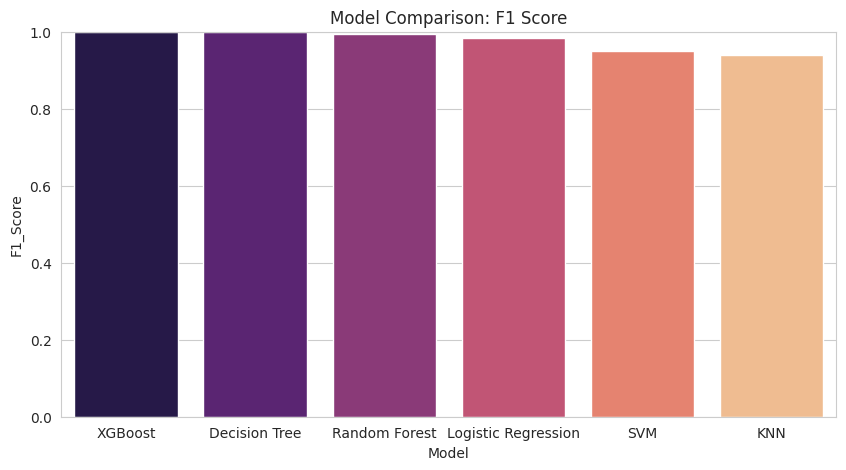

In [ ]:
# ==========================================
# CONSOLIDATED RESULTS TABLE
# ==========================================

df_results = pd.DataFrame(results_list)

# Categorize models
def get_category(name):
    if name in ['Logistic Regression']: return 'Parametric'
    if name in ['Decision Tree', 'KNN', 'SVM']: return 'Non-Parametric'
    return 'Ensemble'

df_results['Category'] = df_results['Model'].apply(get_category)

# Sort by F1 Score (descending)
df_results_sorted = df_results.sort_values(by='F1_Score', ascending=False)

print("--- FINAL MODEL COMPARISON ---")
display(df_results_sorted)

# Visualize Comparison (F1 Score)
plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='F1_Score', data=df_results_sorted, palette='magma')
plt.title('Model Comparison: F1 Score')
plt.ylim(0, 1)
plt.show()